In [ ]:
## Multi-Layer Perceptron for Predicting Badminton Shots in Still Images

In [ ]:
# Import necessary libraries

import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import warnings

# Filter out convergence warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# Preprocessing CSV file and images

def load_and_preprocess_data(csv_path, image_folder):
    # Load CSV
    df = pd.read_csv(csv_path)
    
    # Initialize lists to store image data and labels
    X = []
    y = []
    
    # Define shot types
    shot_types = [' Clear Shot', ' Lift shot', ' Serve', ' Smash Shot']
    
    # Process each image and create labels
    for _, row in df.iterrows():
        # Load and preprocess image
        img_path = os.path.join(image_folder, row['filename'])
        img = Image.open(img_path)
        img = img.resize((64, 64))  # Resize to a manageable size
        img_array = np.array(img).flatten() / 255.0  # Flatten and normalize
        X.append(img_array)
        
        # Create label
        label = shot_types[[row[shot] for shot in shot_types].index(1)]
        y.append(label)
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [ ]:
# Create MLP model and train on images, using MLPClassifier from SKLearn library

def create_and_train_model(X_train, X_val, y_train, y_val):
    mlp = MLPClassifier(
        hidden_layer_sizes=(256, 128, 64),
        activation='relu',
        solver='adam',
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10
    )
    
    mlp.fit(X_train, y_train)
    
    return mlp

In [ ]:
# Evaluate MLP

def evaluate_model(model, X_train, X_val, X_test, y_train, y_val, y_test, le):
    # Make predictions for each set
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    # Calculate errors (Log Loss) for training, validation, and testing
    train_error = log_loss(y_train, model.predict_proba(X_train))
    val_error = log_loss(y_val, model.predict_proba(X_val))
    test_error = log_loss(y_test, model.predict_proba(X_test))
    
    print(f"Training Error (Log Loss): {train_error:.4f}")
    print(f"Validation Error (Log Loss): {val_error:.4f}")
    print(f"Test Error (Log Loss): {test_error:.4f}")
    
    # Print classification reports
    print("\nTraining Set Performance:")
    print(classification_report(y_train, y_train_pred))
    print("\nValidation Set Performance:")
    print(classification_report(y_val, y_val_pred))
    print("\nTest Set Performance:")
    print(classification_report(y_test, y_test_pred))
    
    # Plot confusion matrix for test set
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_,
                yticklabels=le.classes_)
    plt.title('Confusion Matrix (Test Set)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [3]:
# Create visual graphs for the accuracy and error learning curves as the model is trained

def plot_learning_curve(model, X_train, y_train, X_val, y_val, le):
    train_scores = []
    val_scores = []
    train_errors = []
    val_errors = []
    
    for i in range(1, len(model.loss_curve_) + 1):
        model_partial = MLPClassifier(
            hidden_layer_sizes=model.hidden_layer_sizes,
            activation=model.activation,
            solver=model.solver,
            max_iter=i,
            random_state=42
        )
        model_partial.fit(X_train, y_train)
        
        train_scores.append(model_partial.score(X_train, y_train))
        val_scores.append(model_partial.score(X_val, y_val))
        train_errors.append(log_loss(y_train, model_partial.predict_proba(X_train)))
        val_errors.append(log_loss(y_val, model_partial.predict_proba(X_val)))
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(model.loss_curve_) + 1), train_scores, label='Training Accuracy')
    plt.plot(range(1, len(model.loss_curve_) + 1), val_scores, label='Validation Accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Learning Curve (Accuracy)')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(model.loss_curve_) + 1), train_errors, label='Training Error')
    plt.plot(range(1, len(model.loss_curve_) + 1), val_errors, label='Validation Error')
    plt.xlabel('Iterations')
    plt.ylabel('Log Loss')
    plt.title('Learning Curve (Error)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Now that all necessary functions are defined above...

# Set paths for CSV file and badminton images
csv_path = 'filtered_classes.csv'
image_folder = 'images'

# Load and preprocess data
X, y = load_and_preprocess_data(csv_path, image_folder)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [ ]:
# Split data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_encoded, test_size=0.05, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.0947, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Training Error (Log Loss): 1.2081
Validation Error (Log Loss): 1.6813
Test Error (Log Loss): 2.1810

Training Set Performance:
              precision    recall  f1-score   support

           0       0.41      0.30      0.35       225
           1       0.53      0.56      0.55       373
           2       0.94      0.88      0.91       116
           3       0.63      0.69      0.66       563

    accuracy                           0.60      1277
   macro avg       0.63      0.61      0.62      1277
weighted avg       0.59      0.60      0.59      1277


Validation Set Performance:
              precision    recall  f1-score   support

           0       0.16      0.12      0.14        25
           1       0.43      0.49      0.46        37
           2       0.89      0.80      0.84        10
           3       0.56      0.58      0.57        62

    accuracy                           0.49       134
   macro avg       0.51      0.50      0.50       134
weighted avg       0.47      

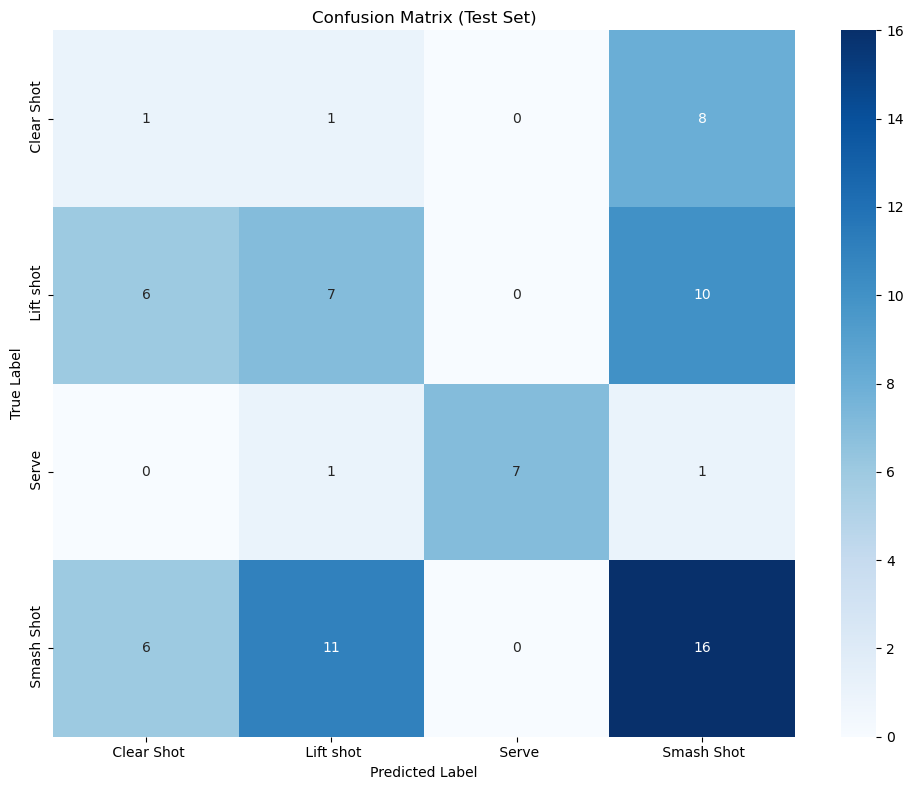

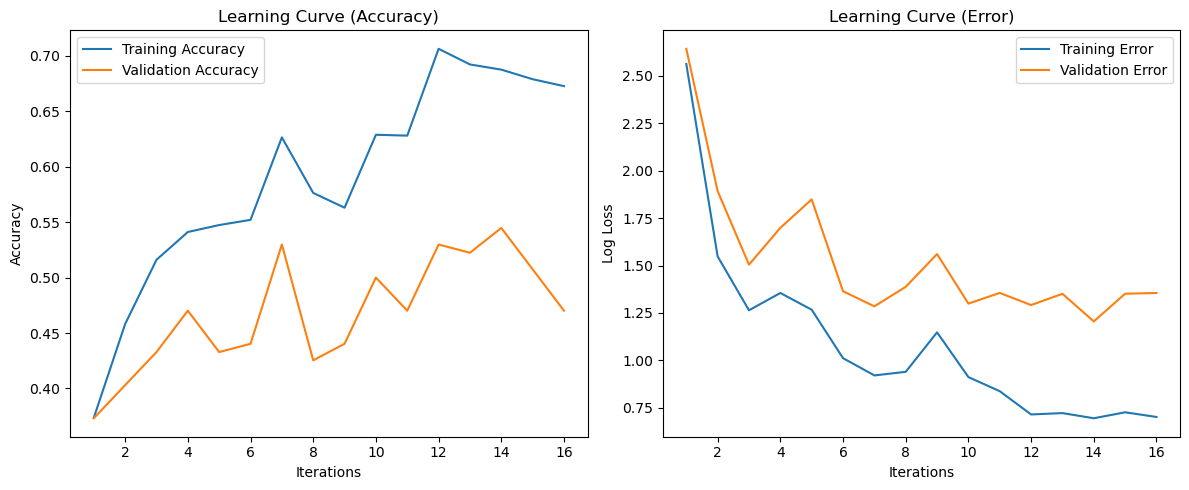

In [5]:
# Create and train model
model = create_and_train_model(X_train_scaled, X_val_scaled, y_train, y_val)

# Evaluate model
evaluate_model(model, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, le)

# Plot learning curve
plot_learning_curve(model, X_train_scaled, y_train, X_val_scaled, y_val, le)